In [3]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)



Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


TODO:
*  figure out how PyG returns graph level predictions (shape of prediction doesnt match shape of labels per batch)

In [4]:
#Dense/Diffpool Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn
import torch_geometric.utils as pygu
import math

class GNN(th.nn.Module):
    def __init__(self, in_c, hidden_c, out_c, normalize=False, lin=True):
        super(GNN, self).__init__()
    
        self.conv = th.nn.ModuleList()
        self.bn = th.nn.ModuleList()

        self.conv.append(tgnn.DenseGCNConv(in_c, hidden_c, normalize))
        self.bn.append(th.nn.BatchNorm1d(hidden_c))

        self.conv.append(tgnn.DenseGCNConv(hidden_c, hidden_c, normalize))
        self.bn.append(th.nn.BatchNorm1d(hidden_c))

        self.conv.append(tgnn.DenseGCNConv(hidden_c, out_c, normalize))
        self.bn.append(th.nn.BatchNorm1d(out_c))

    def forward(self, x, adj, mask=None):
        #batch_size, num_nodes, in_channels = x.size()
        
        for step in range(len(self.conv)):
            #print(x.shape)
            #x = self.bn[step](F.elu(self.conv[step](x, adj, mask)))
            x = F.elu(self.conv[step](x, adj, mask))
        
        return x


#Coarse Grain RNA Classifier Model
class Diff_CG_Classifier(th.nn.Module):
    def __init__(self):
        super(Diff_CG_Classifier, self).__init__()
        num_nodes = math.ceil(0.25 * 50)

        self.gcn_pool1 = GNN(18, 64, num_nodes)
        self.gcn_embed1 = GNN(18, 64, 64)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool2 = GNN(64, 64, num_nodes)
        self.gcn_embed2 = GNN(64, 64, 64, lin=False)

        num_nodes = math.ceil(0.25 * num_nodes)
        self.gcn_pool3 = GNN(64, 64, num_nodes)
        self.gcn_embed3 = GNN(64, 64, 64, lin=False)

        self.gcn_embed4 = GNN(64, 64, 64, lin=False)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(64, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        adj = data.adj #pygu.to_dense_adj(edge_index=edge_index, batch=batch)

        s = self.gcn_pool1(x, adj)
        x = self.gcn_embed1(x, adj)

        x, adj, l1, e1 = tgnn.dense_diff_pool(x, adj, s)

        s = self.gcn_pool2(x, adj)
        x = self.gcn_embed2(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)

        s = self.gcn_pool3(x, adj)
        x = self.gcn_embed3(x, adj)

        x, adj, l2, e2 = tgnn.dense_diff_pool(x, adj, s)

        x = self.gcn_embed4(x, adj)

        #x = tgnn.global_mean_pool(x, batch)
        x = x.mean(dim=1)

        x = self.classify(x)

        return x, l1 + l2, e1 + e2

In [6]:
#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"

training_dataset = CGDataset(training_dir, rmsd_list, transform=T.ToDense(64))

TypeError: __init__() missing 1 required positional argument: 'data_name'

In [119]:
#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd, transform=T.ToDense(64))

Processing...
Done!


In [39]:
import torch_geometric.utils as pygu
print(training_dataset)
print(training_dataset[0])
print(training_dataset.data.x.shape)
print(training_dataset.data.is_undirected())
print(len(training_dataset))
print(training_dataset[0].num_nodes)
print(training_dataset[0].y)
print(training_dataset[0].num_edges)
print(pygu.to_dense_adj(training_dataset[0].edge_index))#to_scipy_sparse_matrix(training_dataset[0].edge_index))
print(training_dataset[0].x.size())

CGDataset(760)
Data(x=[12, 18], edge_index=[2, 24], y=[1])
torch.Size([11769, 18])
True
760
12
tensor([6.5820])
24
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
         [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]])
torch.Size([12, 18])


Epoch 0: Training loss 9.7110, Validation loss 14.8070, learning rate: 0.00100
prediction loss: 0.1776, entropy regularization 2.2009
Epoch 5: Training loss 4.4381, Validation loss 16.5512, learning rate: 0.00100
prediction loss: 0.1552, entropy regularization 2.1532
Epoch 10: Training loss 3.1474, Validation loss 17.7333, learning rate: 0.00100
prediction loss: 0.1291, entropy regularization 2.1955
Epoch 15: Training loss 2.4838, Validation loss 17.1231, learning rate: 0.00100
prediction loss: 0.1387, entropy regularization 2.1718
Epoch 20: Training loss 2.3454, Validation loss 17.5648, learning rate: 0.00100
prediction loss: 0.1649, entropy regularization 2.1792
Epoch 25: Training loss 1.9730, Validation loss 17.6408, learning rate: 0.00099
prediction loss: 0.1379, entropy regularization 2.1409
Epoch 30: Training loss 1.7750, Validation loss 17.6310, learning rate: 0.00099
prediction loss: 0.1501, entropy regularization 2.1640
Epoch 35: Training loss 1.8602, Validation loss 18.5348, 

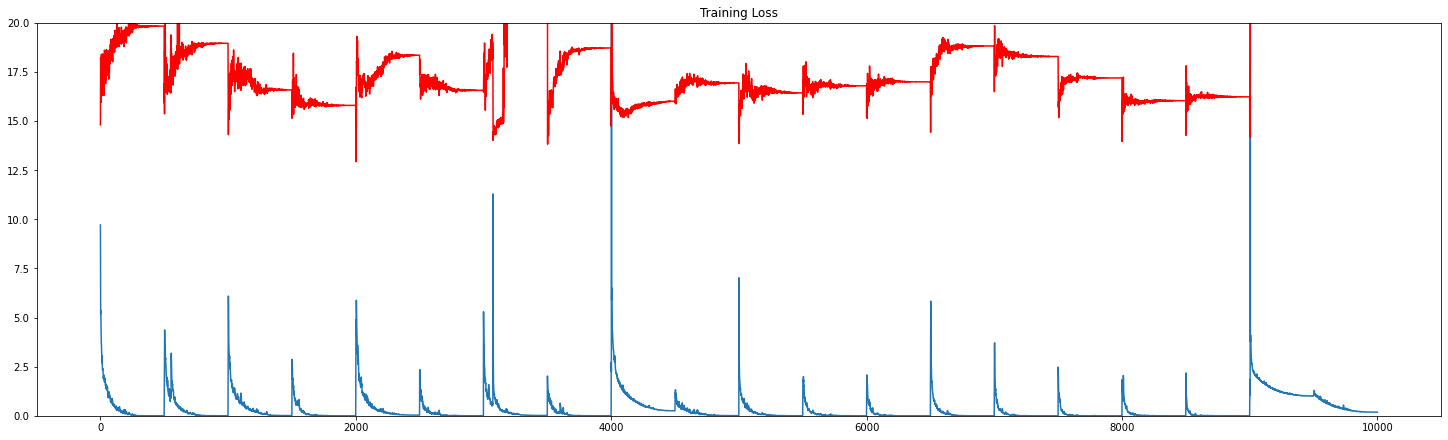

In [135]:
#Training
from torch_geometric.loader import DenseDataLoader
import time
start = time.perf_counter()

model = Diff_CG_Classifier().to(device)

b_size = 64
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True) #
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size) #DenseDataLoader(val_dataset, batch_size=b_size) #

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)#, T_mult=2)
model.train()

epochs = 10000

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data) #, l, e
        loss = F.smooth_l1_loss(pred, data.y, reduction='mean') #(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred, _, _ = model(v_data)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction='mean') #(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        print("prediction loss: {:.4f}, entropy regularization {:.4f}".format(l, e))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
figure, ax = plt.subplots(layout='constrained', figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, 'r')
plt.title("Training Loss")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [63]:
#store training run data

file = "pyg_loss_data_2022-02-17.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [ ]:
#get training run data

file = "pyg_loss_data_2022-02-15.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0002 in epoch 999
Minimum Validation Loss 13.1550 in epoch 607


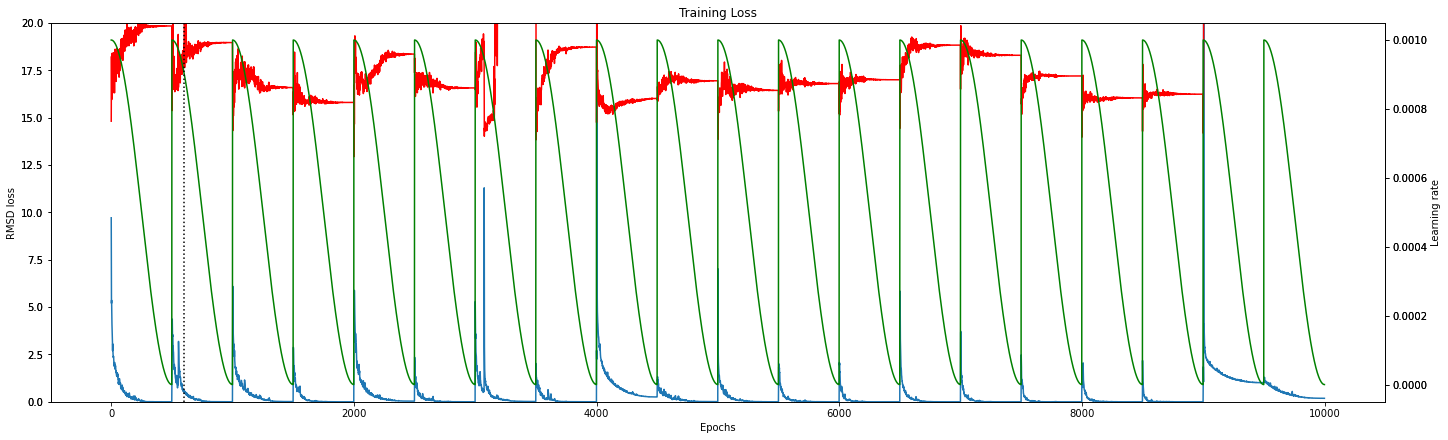

In [145]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = 600, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [139]:
#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd, transform=T.ToDense(64))

test_dataloader = DataLoader(test_dataset)

Processing...
Done!


In [140]:
#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, transform=T.ToDense(64))

st_test_dataloader = DataLoader(st_test_dataset)

Processing...
Done!


Normal Test Set
tensor([23.4710], device='cuda:0') tensor([[23.3951]], device='cuda:0') 0.07589530944824219
tensor([0.], device='cuda:0') tensor([[103.0402]], device='cuda:0') 103.04022979736328
Mean Test loss: 	 17.7584
Std. Dev. of Test loss:  18.8861
Min loss: 		 0.0759
First Quantile: 	 6.1646
Median: 		 11.1980
Third Quantile: 	 20.5713
Max Loss: 		 103.0402


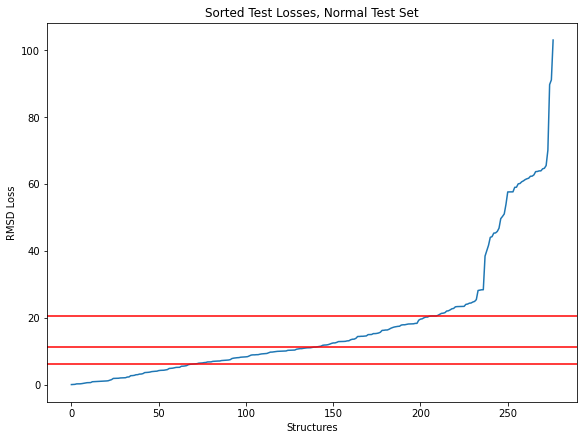

5S rRNA and tRNA Test Set
tensor([19.2860], device='cuda:0') tensor([[19.3007]], device='cuda:0') 0.014734268188476562
tensor([0.], device='cuda:0') tensor([[114.8037]], device='cuda:0') 114.80374908447266
Mean Test loss: 	 8.8823
Std. Dev. of Test loss:  15.8764
Min loss: 		 0.0147
First Quantile: 	 1.8366
Median: 		 3.9895
Third Quantile: 	 7.1819
Max Loss: 		 114.8037


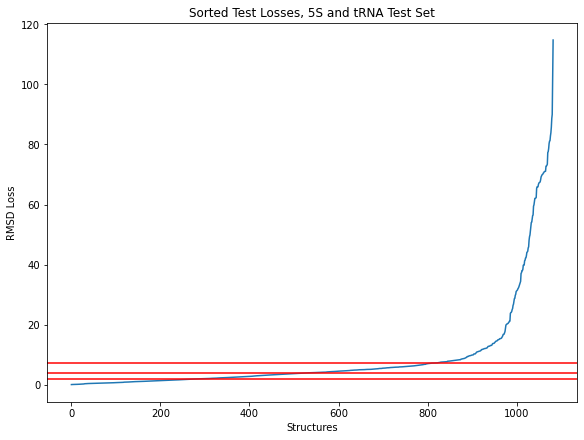

In [146]:
#Test
import math

if "model" not in globals():
    model = Diff_CG_Classifier(num_features=3)

model.to(device)

model.load_state_dict(th.load("pyg_model_data/model_epoch5400.pth"))

model.eval()

with th.no_grad():
    for loader in [test_dataloader, st_test_dataloader]:
        max_label = 0
        max_loss = 0
        max_pred = 0
        min_label = math.inf
        min_loss = math.inf
        min_pred = math.inf
        test_losses = []
        for test_graph in loader:
            test_graph = test_graph.to(device)
            test_pred, _, _ = model(test_graph)
            test_loss = F.l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #smooth_l1_loss #(test_pred, test_graph.y).item() #
            test_losses.append(test_loss)
            if test_loss > max_loss:
                max_loss = test_loss
                max_label = test_graph.y
                max_pred = test_pred
            if test_loss < min_loss:
                min_loss = test_loss
                min_label = test_graph.y
                min_pred = test_pred
            if test_pred < 0:
                print(test_graph.y, test_pred)

        if loader == test_dataloader:
            print("Normal Test Set")
        elif loader == st_test_dataloader:
            print("5S rRNA and tRNA Test Set")
        print(min_label, min_pred, min_loss)
        print(max_label, max_pred, max_loss)
        test_mean = np.mean(test_losses)
        test_std = np.std(test_losses)
        test_fq = np.quantile(test_losses, q = 0.25)
        test_median = np.median(test_losses)
        test_tq = np.quantile(test_losses, q = 0.75)
        print("Mean Test loss: \t {:.4f}".format(test_mean))
        print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
        print("Min loss: \t\t {:.4f}".format(min(test_losses)))
        print("First Quantile: \t {:.4f}".format(test_fq))
        print("Median: \t\t {:.4f}".format(test_median))
        print("Third Quantile: \t {:.4f}".format(test_tq))
        print("Max Loss: \t\t {:.4f}".format(max(test_losses)))

        #print(sorted(test_losses)[-5:])

        fig, axs = plt.subplots(layout='constrained', figsize=(8, 6))
        axs.plot(sorted(test_losses))
        #plt.title("Sorted Test Losses")
        if loader == test_dataloader:
            plt.title("Sorted Test Losses, Normal Test Set")
        elif loader == st_test_dataloader:
            plt.title("Sorted Test Losses, 5S and tRNA Test Set")
        plt.ylabel("RMSD Loss")
        plt.xlabel("Structures")
        plt.axhline(y = test_fq, color = 'r')
        plt.axhline(y = test_median, color = 'r')
        plt.axhline(y = test_tq, color = 'r')
        plt.show()